In [37]:
from matplotlib import pyplot as plt
import tensorflow as tf
#from tensorflow import keras
#Используем костыль для исправления IntelliSense для keras по гайду:
#https://stackoverflow.com/questions/71000250/import-tensorflow-keras-could-not-be-resolved-after-upgrading-to-tensorflow-2
import keras.api._v2.keras as keras
from keras import layers
from keras import losses
#from keras.datasets import CIFAR100
import numpy as np
import tensorflow_datasets as tfds
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [38]:


size=32
input_shape = (size, size, 1)
num_classes=196
(ds_train, y_test), ds_info = tfds.load(
    'cars196',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)
print(ds_info.features['label'])
def prepare_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    #output = tf.image.crop_and_resize(image, boxes, box_indices, CROP_SIZE)
    
    image2=tf.image.central_crop(image,1)
    image3=tf.image.resize(image2,[size,size])
    #image4=tf.image.no
    image4=tf.image.rgb_to_grayscale(image3)
    #label = keras.utils.to_categorical(label, num_classes)
    return tf.cast(image4, tf.float16) / 255., label

ds_train = ds_train.map(prepare_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.map(prepare_img, num_parallel_calls=tf.data.AUTOTUNE)

ds_train = ds_train.batch(1000)
ds_test=ds_test.batch(1000)
for image,label in ds_train:
    #print(label)
    #print()
    #print(image)
    plt.imshow(tf.cast(image[0].reshape((size,size,1)),dtype=tf.float32), interpolation='nearest')
    plt.show()
    break

ds_train.

ClassLabel(shape=(), dtype=tf.int64, num_classes=196)


InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Matrix size-incompatible: In[0]: [1024000,1], In[1]: [3,1]
	 [[{{node rgb_to_grayscale/Tensordot/MatMul}}]] [Op:IteratorGetNext]

In [63]:
from keras.layers import Convolution2D, Input

def define_skip_model():
    inputs = keras.Input(shape=input_shape, name="img")
    x = layers.Conv2D(64,(3,3), activation="relu")(inputs)
    x = layers.Conv2D(64, (3,3), activation="relu")(x)
    #x = layers.Dropout(0.2)(x)
    block_1_output = layers.MaxPooling2D(3)(x)
    #block_1_output = layers.BatchNormalization()(block_1_output)
    
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(block_1_output)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    #x = layers.Dropout(0.2)(x)
    block_2_output = layers.concatenate([x, block_1_output])
    #block_2_output = layers.BatchNormalization()(block_2_output)

    x = layers.Conv2D(256, 3, activation="relu", padding="same")(block_2_output)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
    #x = layers.Dropout(0.2)(x)
    block_3_output = layers.concatenate([x, block_2_output])
    #block_3_output = layers.BatchNormalization()(block_3_output)
    
    '''x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_3_output)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    block_4_output = layers.concatenate([x, block_3_output])
    
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(block_4_output)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    block_5_output = layers.concatenate([x, block_4_output])

    x = layers.Conv2D(64, 3, activation="relu")(block_5_output)'''
    x = layers.Conv2D(512, 3, activation="relu")(block_3_output)
    x = layers.GlobalAveragePooling2D()(x)
    #x = layers.Dense(num_classes*2, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs, name="toy_resnet")
    return model
model=define_skip_model()
print(model.summary())

Model: "toy_resnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_85 (Conv2D)             (None, 30, 30, 64)   640         ['img[0][0]']                    
                                                                                                  
 conv2d_86 (Conv2D)             (None, 28, 28, 64)   36928       ['conv2d_85[0][0]']              
                                                                                                  
 max_pooling2d_12 (MaxPooling2D  (None, 9, 9, 64)    0           ['conv2d_86[0][0]']              
 )                                                                                       

In [64]:
def compile2():
    model.compile(
        loss=losses.SparseCategoricalCrossentropy(),
        optimizer=tf.optimizers.Adam(lr=0.01),
        metrics=['accuracy']
    )

In [65]:
#model.fit(x_train,y_train,batch_size=1,epochs=5,shuffle=True)

In [66]:
x_test=None
y_test=None
for x_test2, y_test2 in ds_test:
    #data=list(ds_test.take(1))
    x_test=x_test2
    y_test=y_test2
    #y_test= keras.utils.to_categorical(np.array(y_test), num_classes)
   # print(x_test)
    #print(y_test)
    break

In [71]:
compile2()
#print("x_train=",x_train.shape,"y_train",y_train.shape)
#model.save("saved_model_CNN/learn_epoch_start.h5")

x_train=tfds.as_numpy(ds_train)
for i in range(1,20):
    print("Epoch "+str(i))
    #for x_train,y_train in ds_train:
    #
    #y_train = keras.utils.to_categorical(y_train, num_classes)

    #model.save('saved_model_CNN/learn_epoch_start='+str(i)+".h5")

   # (x_test,y_test)=ds_test.take(100)
    model.fit(x_train,y_train,batch_size=500,epochs=1,shuffle=True,validation_data=(x_test,y_test))
    #results=model.evaluate(x_test,y_test,batch_size=50,verbose=2)
    #print(str(results))
    #,validation_data=(x_test,y_test)
    #model.save('saved_model_CNN/learn_epoch_end='+str(i)+".h5")
#results=model.evaluate(x_test,y_test,batch_size=50,verbose=2)
#print(str(results))
model.save("saved_model_CNN/learn_done.h5")

C:\Users\PlayerPC\Miniconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


TypeError: Arguments to as_numpy must be tf.Tensors or tf.data.Datasets. Got: <class 'tensorflow_datasets.core.dataset_utils._IterableDataset'>.

In [ ]:
#Без dropout было явное переобучение train 90 пртив test 45
#print("x_train=",x_train.shape,"y_train",y_train.shape)
model.save("saved_model_CNN2/CIFAR100_learn_epoch_start.h5")
for i in range(1,10):
    print("Epoch "+str(i))
    model.save('saved_model_CNN2/CIFAR100_learn_epoch_start='+str(i)+".h5")
    model.fit(x_train,y_train,batch_size=25,epochs=1,shuffle=True,validation_data=(x_test,y_test))
    #,validation_data=(x_test,y_test)
    
    
    model.save('saved_model_CNN2/CIFAR100_learn_epoch_end='+str(i)+".h5")
results=model.evaluate(x_test,y_test,batch_size=50,verbose=2)
print(str(results))
model.save("saved_model_CNN2/CIFAR100_learn_done.h5")

In [6]:
model.load_weights("saved_model_CNN2/CIFAR100_learn_epoch_end=8.h5")
model.compile(
    loss=losses.CategoricalCrossentropy(),
    optimizer=tf.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [7]:
#Без dropout было явное переобучение train 90 пртив test 45
#print("x_train=",x_train.shape,"y_train",y_train.shape)
model.save("saved_model_CNN3/CIFAR100_learn_epoch_start.h5")
for i in range(1,3):
    print("Epoch "+str(i))
    model.save('saved_model_CNN3/CIFAR100_learn_epoch_start='+str(i)+".h5")
    model.fit(x_train,y_train,batch_size=25,epochs=1,shuffle=True,validation_data=(x_test,y_test))
    #,validation_data=(x_test,y_test)
    
    
    model.save('saved_model_CNN3/CIFAR100_learn_epoch_end='+str(i)+".h5")
results=model.evaluate(x_test,y_test,batch_size=50,verbose=2)
print(str(results))
model.save("saved_model_CNN3/CIFAR100_learn_done.h5")

Epoch 1
 614/2000 [========>.....................] - ETA: 16s - loss: 3.1998 - accuracy: 0.2230

KeyboardInterrupt: 

In [ ]:
#model.fit(x_train,y_train,batch_size=32,epochs=5)

In [8]:
#model.load_weights("saved_model3/ECIFAR100_learn_epoch_start.h5")

313/313 - 1s - loss: 0.0398 - accuracy: 0.9875 - 1s/epoch - 3ms/step
[0.039796166121959686, 0.987500011920929]
8440
(28, 28, 3)
(28, 28, 1)
1/1 [==============================] - 0s 24ms/step
9


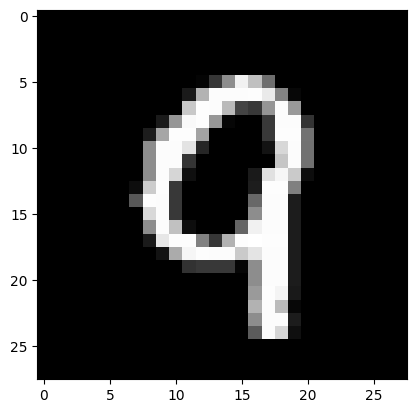

In [12]:
results=model.evaluate(x_test,y_test,batch_size=32,verbose=2)
print(str(results))
value=np.random.randint(0,10000)
print(value)
for id in range(len(y_train)):
    #print(labels[id])
    #break
    #22 - M big
    if(y_train.argmax()==7):
        value=id
        break
        


#print(x_train[value].shape)

single=x_train[value]
image=np.zeros((28,28,3))
print(image.shape)

for y in range(0,image.shape[0]):
    for x in range(0,image.shape[1]):
        for c in range(0,image.shape[2]):
            image[y,x,c]=single[y][x]



print(single.shape)
#print(single)

singleReady=np.zeros((1,28,28))

for y in range(0,image.shape[0]):
    for x in range(0,image.shape[1]):
            singleReady[0][y][x]=single[y][x]

print(model.predict(singleReady,batch_size=1).argmax())

plt.imshow(image)
plt.show()

In [13]:
model.save('saved_model_CNN/CIFAR100_byclass_done.h5')

In [14]:
#results=model.evaluate(x_test,y_test,batch_size=32,verbose=2)
#print(str(results))
#value=np.random.randint(0,10000)

id=22
for v in y_train:
    if(v.argmax()==id):
        print(id)
        ShowImage(v)
        break
        #id+=1
currentIteration=0
'''for v in y_train:
    if(v==id):
        print(id,v)
        ShowImage(v)
        currentIteration+=1
        id+=1    
    if(currentIteration==10):
        break'''


def ShowImage(value:int):
    print(x_train[value].shape)

    single=x_train[value]
    image=np.zeros((28,28,3))
    print(image.shape)

    for y in range(0,image.shape[0]):
        for x in range(0,image.shape[1]):
            for c in range(0,image.shape[2]):
                image[y,x,c]=single[y*28+x]



    #print(single.shape)
    #print(single)

    #singleReady=np.zeros((1,28*28))

    #for y in range(0,image.shape[0]):
    #    for x in range(0,image.shape[1]):
    #            singleReady[0][y*28+x]=single[y*28+x]

    #print(model.predict(singleReady,batch_size=1).argmax())

    plt.imshow(image)
    plt.show()

In [17]:
from PIL import Image
IMG = np.asarray(Image.open('E:/JupyterLab/Tensorflow_FKI_fall_2022/2022.10.07/Segmented/9.png'))

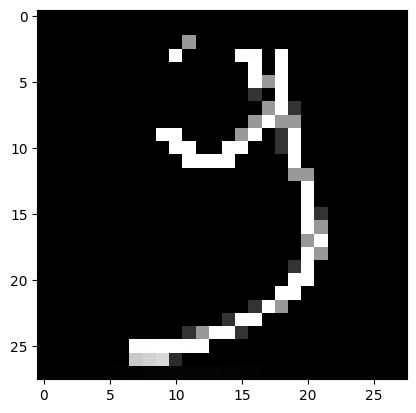

(28, 28, 3)
(1, 28, 28)


In [30]:
plt.imshow(IMG)
plt.show()
print(IMG.shape)

IMG_2=np.zeros((1,28,28),dtype="float32")

for x in range(28):
    for y in range(28):
        IMG_2[0][x][y]=IMG[x][y][0]/255.
print(IMG_2.shape)

In [32]:
print(model.predict(IMG_2,batch_size=1).argmax())

1/1 [==============================] - 0s 26ms/step
3
